<a href="https://colab.research.google.com/github/djsabelo/BiosignalsDeepLearningWorkshop/blob/dev/BiosignalSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Fazer o x e o y
2. Cross validation data
3. Optimizer
4. Setup do tensorboard - fazer callback para gravar numa variavel do loss
5. Make model
6. Train model
7. See loss function;
8. Try different parameters, namely learning rate
9. Plot Results
11. Plot softmax with signal
10. Plot R^2 and print metrics
11. Synthesize model
12. Plot synthesized signal
13. Plot previously synthesized 


In [1]:
!git clone https://github.com/djsabelo/BiosignalsDeepLearningWorkshop.git

fatal: destination path 'BiosignalsDeepLearningWorkshop' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Find files in folder
folder = './BiosignalsDeepLearningWorkshop/data/'
filename = "segments.npz"

# Define sampling frequency
fs = 250

data = np.load(folder + filename)

for key in data.keys():
  print(key)


segments
window_size
overlap
quantization
decimate
smoothing


In [3]:
# Parameters
window_size = data["window_size"]
quantization = data["quantization"]
overlap = data["overlap"]

segments = data["segments"]
print(np.shape(segments))

#Expected Output:
#(5, 8997, 65)


(5, 8997, 65)


In [4]:
x = segments[0,:512,:-1]
y = segments[0,:512,1:]


print(np.shape(x))
print(np.shape(y))

# Expected Output:
# (8997, 64)
# (8997, 64)

(512, 64)
(512, 64)


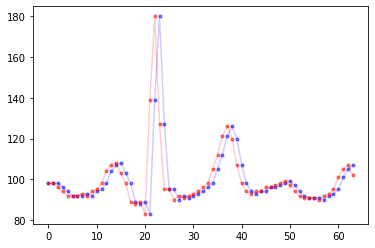

In [5]:
random_index = np.random.randint(len(segments))

plt.plot(x[random_index, :64], 'b.', alpha=0.5)
plt.plot(x[random_index, :64], 'b', alpha=0.2)
plt.plot(y[random_index, :64], 'r.', alpha=0.5)
plt.plot(y[random_index, :64], 'r', alpha=0.2)

In [6]:
import math

# cross validation of first 70% for training data and last 30% of test data
last_train_index = int(0.7 * len(x))

x_train = x[:last_train_index]
y_train = y[:last_train_index]

first_test_index = int(last_train_index + math.ceil(window_size/overlap) + 1) # to ensure the test data does not overlap with train data

x_test = x[first_test_index:]
y_test = y[first_test_index:]

print("Number of rejected windows: {}".format(first_test_index - last_train_index))
print("Number of training windows: {}; Percentage: {} %".format(len(x_train), (len(x_train)*100/len(x))))
print("Number of testing windows: {}; Percentage: {} %".format(len(x_test), (len(x_test)*100/len(x))))


# Expected Output:
# Number of rejected data: 5
# Number of training windows: 6297; Percentage: 69.98999666555518 %
# Number of testing windows: 2689; Percentage: 29.887740357897076 %


Number of rejected windows: 5
Number of training windows: 358; Percentage: 69.921875 %
Number of testing windows: 149; Percentage: 29.1015625 %


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

encoder_hidden_neurons = 256
decoder_hidden_neurons = 256
dense_layer_neurons = 512

print("Input layer:")

encoder_input = layers.Input(shape=(window_size,))
encoder_embedded = layers.Embedding(input_dim=quantization, output_dim=encoder_hidden_neurons)(
    encoder_input
)
print(encoder_input)
print("")

print("Embedded layer:")
print(encoder_embedded)
print("")
# Return states in addition to output
e_output, state_h = layers.GRU(encoder_hidden_neurons, 
                               return_state=True, 
                               return_sequences=True, 
                               name="encoder")(encoder_embedded)
print("GRU layers:")
print("First layer:")
print(e_output)
print(state_h)
print("")

print("Second layer:")
# Pass the state to a new GRU layer, as initial state
e_output, state_h  = layers.GRU(decoder_hidden_neurons, return_state=True, return_sequences=True, name="encoder_2")(
    e_output, initial_state=[state_h]
)
print(e_output)
print(state_h)
print("")

print("Third layer:")
# Pass the state to a new GRU layer, as initial state
decoder_output = layers.GRU(decoder_hidden_neurons, return_sequences=True, name="decoder")(
    e_output, initial_state=[state_h]
)
print(e_output)
print(state_h)
print("")

print("Latent layer:")
latent = layers.Dense(quantization)(decoder_output)
print(latent)
print("")

print("Softmax layer:")
probs = layers.Softmax()(latent)
print(probs)
print("")

print("Output layer:")
output = tf.math.argmax(
    probs, axis=2, output_type=tf.dtypes.int64, name="output"
)
print(output)

# Expected output
# Input layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_15'), name='input_15', description="created by layer 'input_15'")
#
# Embedded layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='embedding_7/embedding_lookup/Identity_1:0', description="created by layer 'embedding_7'")
#
# GRU layers:
# First layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='encoder/PartitionedCall:1', description="created by layer 'encoder'")
# KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='encoder/PartitionedCall:2', description="created by layer 'encoder'")
#
# Second layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:1', description="created by layer 'encoder_2'")
# KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:2', description="created by layer 'encoder_2'")
#
# Third layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 128), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:1', description="created by layer 'encoder_2'")
# KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:2', description="created by layer 'encoder_2'")
#
# Latent layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1000), dtype=tf.float32, name=None), name='dense_5/BiasAdd:0', description="created by layer 'dense_5'")
#
# Softmax layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1000), dtype=tf.float32, name=None), name='softmax_5/Softmax:0', description="created by layer 'softmax_5'")
#
# Output layer:
# KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), name='tf.math.argmax_5/ArgMax:0', description="created by layer 'tf.math.argmax_5'")


Input layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")

Embedded layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None), name='embedding/embedding_lookup/Identity_1:0', description="created by layer 'embedding'")

GRU layers:
First layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None), name='encoder/PartitionedCall:1', description="created by layer 'encoder'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='encoder/PartitionedCall:2', description="created by layer 'encoder'")

Second layer:
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 256), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:1', description="created by layer 'encoder_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='encoder_2/PartitionedCall:2', des

In [8]:
model = keras.Model(encoder_input, probs)
model.summary()

# Expected output
# Model: "model"
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_11 (InputLayer)           [(None, 64)]         0                                            
# __________________________________________________________________________________________________
# embedding_2 (Embedding)         (None, 64, 128)      128000      input_11[0][0]                   
# __________________________________________________________________________________________________
# encoder (GRU)                   [(None, 64, 128), (N 99072       embedding_2[0][0]                
# __________________________________________________________________________________________________
# encoder_2 (GRU)                 [(None, 64, 128), (N 99072       encoder[0][0]                    
#                                                                  encoder[0][1]                    
# __________________________________________________________________________________________________
# decoder (GRU)                   (None, 64, 128)      99072       encoder_2[0][0]                  
#                                                                  encoder_2[0][1]                  
# __________________________________________________________________________________________________
# dense (Dense)                   (None, 64, 1000)     129000      decoder[0][0]                    
# __________________________________________________________________________________________________
# softmax (Softmax)               (None, 64, 1000)     0           dense[0][0]                      
# ==================================================================================================
# Total params: 554,216
# Trainable params: 554,216
# Non-trainable params: 0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 256)      256000      input_1[0][0]                    
__________________________________________________________________________________________________
encoder (GRU)                   [(None, 64, 256), (N 394752      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_2 (GRU)                 [(None, 64, 256), (N 394752      encoder[0][0]                    
                                                                 encoder[0][1]                

In [9]:
class show_intermediate_outputs(tf.keras.callbacks.Callback):
    """
    Callback class for Keras to run prediction on a model
    It will save the results of the model to a file after plotting
    """

    def __init__(self, model, x_example):
        """
        `input_names` should be a list of graph names
        """
      
        self.model = model
        self.x_example = x_example
        self.predicts = [np.argmax(self.model.predict(self.x_example), axis=2)]
    
    def on_batch_end(self, batch, logs=None):              
        self.predicts.append(np.argmax(self.model.predict(self.x_example), axis=2))

    #def on_epoch_end(self, batch, logs=None):              
    #    self.predicts.append(np.argmax(self.model.predict(self.x_example), axis=2))

class save_losses(tf.keras.callbacks.Callback): 
    """
    Save the losses, mse, and accuracy of a model to a file in the intermediates folder
    """
    def __init__(self, model_name):
        # Make sure the test model save path exists
        if not os.path.exists("intermediates/"):
            os.mkdir("intermediates/")
        self.model_name = model_name

        self.metric_file = open("intermediates/metrics.txt", 'a')

    def on_train_begin(self, logs={}):
        self.losses = []
        self.mses = []
        self.acc = []

    # Save to a file when the training ends
    def on_train_end(self, logs={}):

        self.metric_file.write("\n\n" + self.model_name + "\n")
        average_loss = np.average(self.losses)
        self.metric_file.write("{}".format(self.losses))

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        if logs.get('mse'):
            self.mses.append(logs.get('mse'))
 

In [10]:
model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              "mse", 
              metrics=[tf.metrics.Precision(), tf.metrics.Recall()])

In [11]:
import os 

checkpoint_path = "/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,   
                                                 save_freq= 1000*10)
predict_callback = show_intermediate_outputs(model, x_train[random_index])
loss_history_callback = save_losses("ECG_synthesis")


In [43]:
epochs = 1000
batch_size = 32


model.fit(x_train, 
          np.identity(quantization)[y_train], 
          callbacks=[loss_history_callback, save_callback, predict_callback], 
          epochs=epochs, 
          batch_size=batch_size, 
          shuffle=True)

model.save_weights("hr_detect_checkpoint2")
model.evaluate(x_test, np.identity(quantization)[y_test], verbose=1)



Epoch 1/200
45/45 [==============================] - 25s 546ms/step - loss: 3.0233e-05 - precision: 0.9986 - recall: 0.9709
Epoch 2/200
45/45 [==============================] - 24s 544ms/step - loss: 3.0225e-05 - precision: 0.9986 - recall: 0.9709
Epoch 3/200
45/45 [==============================] - 25s 548ms/step - loss: 3.0212e-05 - precision: 0.9986 - recall: 0.9709
Epoch 4/200
45/45 [==============================] - 24s 542ms/step - loss: 3.0204e-05 - precision: 0.9986 - recall: 0.9709
Epoch 5/200
45/45 [==============================] - 24s 545ms/step - loss: 3.0190e-05 - precision: 0.9986 - recall: 0.9709
Epoch 6/200
45/45 [==============================] - 25s 546ms/step - loss: 3.0172e-05 - precision: 0.9986 - recall: 0.9709
Epoch 7/200
45/45 [==============================] - 25s 549ms/step - loss: 3.0050e-05 - precision: 0.9986 - recall: 0.9711
Epoch 8/200
45/45 [==============================] - 25s 552ms/step - loss: 3.0035e-05 - precision: 0.9986 - recall: 0.9711
Epoch 9/

[0.0010478823678568006, 0.39009734988212585, 0.3403942883014679]

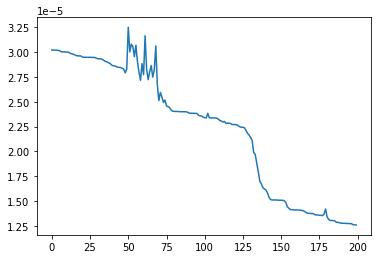

In [44]:
plt.plot(loss_history_callback.losses)

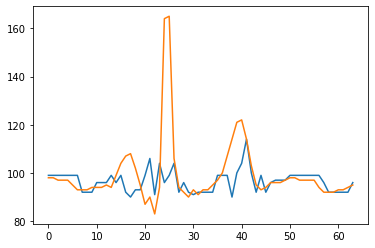

In [45]:

random_record = np.random.randint(len(x_train))
plt.plot(np.argmax(model.predict(x_train[random_record]), axis=2))
plt.plot(y_train[random_record])

R^2: 0.9622860074833952


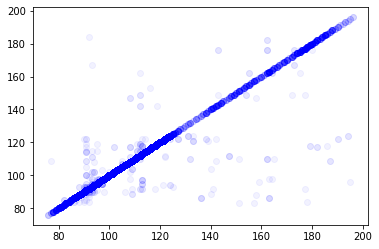

In [46]:
from sklearn.metrics import r2_score

train_predictions = np.argmax(model.predict(x_train), axis=2)
plt.scatter(train_predictions, y_train, alpha=0.05, color="blue")
print("R^2: {}".format(r2_score(y_train, train_predictions)))

R^2: 0.7102794777059651


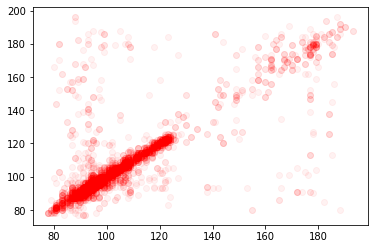

In [47]:
test_predictions = np.argmax(model.predict(x_test), axis=2)
plt.scatter(test_predictions, y_test, alpha=0.05, color="red")
print("R^2: {}".format(r2_score(y_test, test_predictions)))

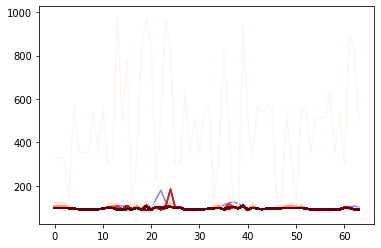

In [48]:

from matplotlib import cm
reds = cm.get_cmap('Reds', 12)

plt.plot(y_train[random_index], "b", alpha=0.5)
for i, prediction in enumerate(predict_callback.predicts[0:-1:10]):
  plt.plot(prediction, alpha=1, color=reds((i+1)/len(predict_callback.predicts[0:-1:10])))